This example illustrates fitting and comparing several Machine Learning algorithms for classifying the binary target in the         
jordan_mining data set.

The steps include:                              
                                                                      
1. PREPARE AND EXPLORE  
  a) Check data is loaded into CAS                               
<br>                                                                      
2. PERFORM SUPERVISED LEARNING  
  a) Fit a model using a Random Forest  
  b) Fit a model using Gradient Boosting  
  c) Fit a model using a Neural Network  
  d) Fit a model using a Support Vector Machine                       
<br>                                                                      
3. EVALUATE AND IMPLEMENT  
  a) Score the data  
  b) Assess model performance  
  c) Generate ROC and Lift charts                                  

### Import packages

In [1]:
from swat import *
import swat
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
from pandas import*
from swat.render import render_html
import seaborn as sns
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### CAS Server connection details

In [2]:
cashost='eeclxvm128b.unx.sas.com'
casport=5570
casauth='~/.authinfo'
indata_dir="/home/sasdemo/data"
indata="jordan_mining"
table=indata_dir+"/"+indata+".sas7bdat"
shot_df=pd.read_sas(table)

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo="~/.authinfo", caslib="casuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")
sess.loadactionset(actionset="clustering")

NOTE: Added action set 'dataStep'.


[actionset]

 'dataStep'

+ Elapsed: 0.00115s, sys: 0.001s, mem: 0.0577mb

NOTE: Added action set 'dataPreprocess'.


[actionset]

 'dataPreprocess'

+ Elapsed: 0.000135s, mem: 0.0281mb

NOTE: Added action set 'cardinality'.


[actionset]

 'cardinality'

+ Elapsed: 0.000549s, mem: 0.0292mb

NOTE: Added action set 'sampling'.


[actionset]

 'sampling'

+ Elapsed: 0.00144s, sys: 0.001s, mem: 0.033mb

NOTE: Added action set 'regression'.


[actionset]

 'regression'

+ Elapsed: 0.00123s, sys: 0.001s, mem: 0.0326mb

NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.000953s, sys: 0.001s, mem: 0.0291mb

NOTE: Added action set 'neuralNet'.


[actionset]

 'neuralNet'

+ Elapsed: 0.00168s, user: 0.001s, sys: 0.000999s, mem: 0.0352mb

NOTE: Added action set 'svm'.


[actionset]

 'svm'

+ Elapsed: 0.00095s, user: 0.001s, mem: 0.0363mb

NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.000394s, mem: 0.0331mb

NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000128s, mem: 0.0285mb

NOTE: Added action set 'clustering'.


[actionset]

 'clustering'

+ Elapsed: 0.000589s, sys: 0.001s, mem: 0.0295mb

### Load data into CAS if needed

In [5]:
if not sess.table.tableExists(table=indata).exists:
    tbl = sess.upload_file(indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the uploaded file available as table JORDAN_MINING in caslib CASUSER(sasdemo).
NOTE: The table JORDAN_MINING has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


#### View first 5 observations from the data set

In [6]:
sess.fetch(table=indata, to=5)

,ID,SEASON,GAME_ID,season_type,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,...,Lead_Player_Before,LAST_MINUTE,LOC_X_MINUS,LOC_Y_MINUS,end_of_game,Overtime,Last_quarter,close_game,pressure,Made
0,0029600001_43,1996-97,0029600001,Regular Season,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),8-16 ft.,...,leading,not last minute,-45.0,-148.0,Not End of Game,Regular,<4,Close Game,0.0,0.0
1,0029600001_38,1996-97,0029600001,Regular Season,Missed Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,...,trailing,not last minute,231.0,-86.0,Not End of Game,Regular,<4,Close Game,0.0,0.0
2,0029600001_57,1996-97,0029600001,Regular Season,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,...,trailing,not last minute,-114.0,-108.0,Not End of Game,Regular,<4,Not Close,0.0,1.0
3,0029600001_65,1996-97,0029600001,Regular Season,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,trailing,not last minute,133.0,-110.0,Not End of Game,Regular,<4,Close Game,0.0,1.0
4,0029600001_78,1996-97,0029600001,Regular Season,Missed Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,...,trailing,not last minute,-233.0,1.0,Not End of Game,Regular,<4,Close Game,0.0,0.0


#### Set Target and Inputs

In [7]:
target          = "Made"
class_inputs    = ["_CLUSTER_ID_","Lead_Player_Before", "ACTION_TYPE", "SHOT_TYPE", "SHOT_ZONE_BASIC", "SHOT_ZONE_AREA", "Homegame", "end_of_game","Overtime","close_game","pressure"]
class_vars      = [target] + class_inputs
interval_inputs = ["Shot_Distance"]
all_inputs      = interval_inputs + class_inputs

###PLOT SHOT CHART

/opt/sasinside/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


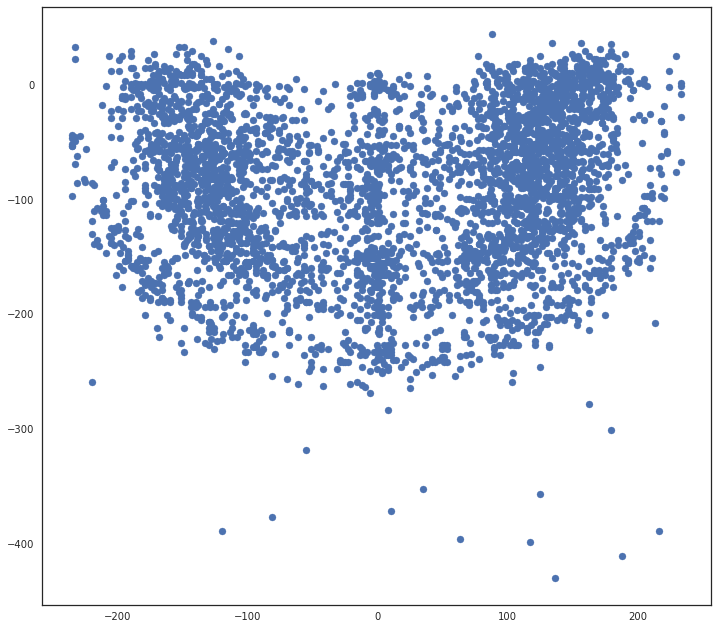

In [8]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(shot_df.LOC_X, -shot_df.LOC_Y)
plt.show()


PLOT SHOTS AND COURT

(-250, 250)

(422.5, -47.5)

/opt/sasinside/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


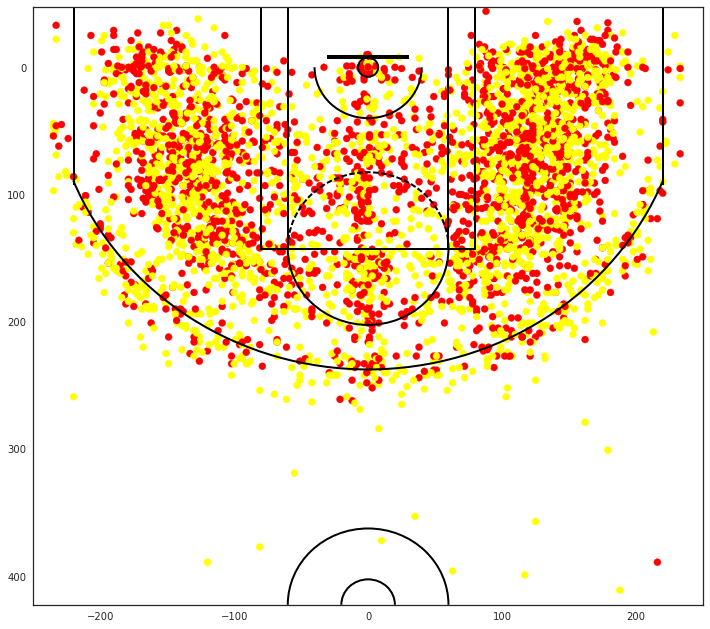

In [9]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

import pylab


plt.figure(figsize=(12,11))
plt.scatter(shot_df.LOC_X, shot_df.LOC_Y,c=shot_df.Made,cmap=pylab.cm.autumn_r)
draw_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
# plt.tick_params(labelbottom=False, labelleft=False)
plt.show()


Stats and Graphs

/opt/sasinside/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/sasinside/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-250, 250)

(422.5, -47.5)

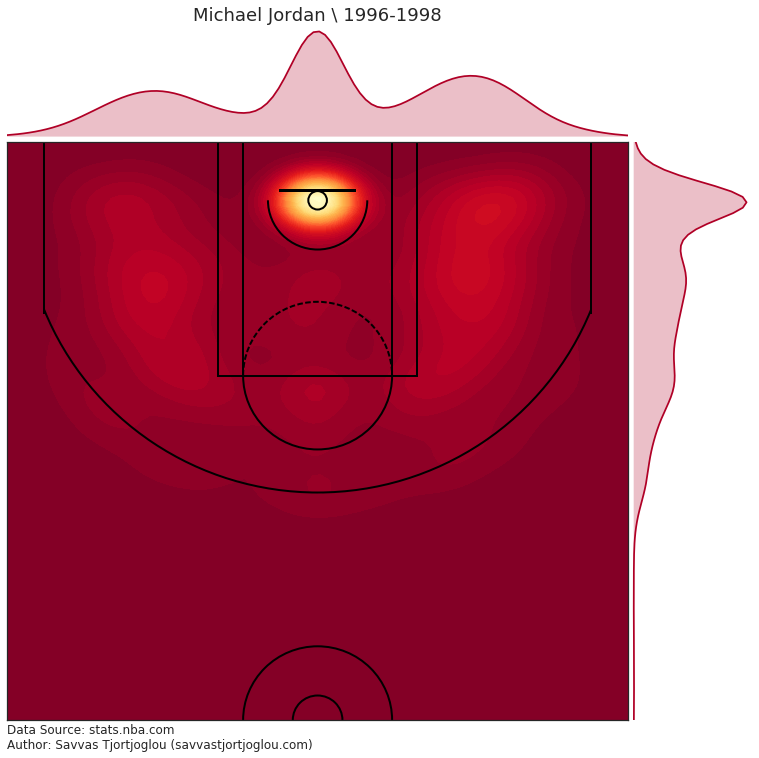

In [10]:
from matplotlib.offsetbox import  OffsetImage

# create our jointplot

# get our colormap for the main kde plot
# Note we can extract a color from cmap to use for 
# the plots that lie on the side and top axes
cmap=plt.cm.YlOrRd_r 

# n_levels sets the number of contour lines for the main kde plot
joint_shot_chart = sns.jointplot(shot_df.LOC_X, shot_df.LOC_Y, stat_func=None,
                                 kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=50)

joint_shot_chart.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('Michael Jordan \ 1996-1998', 
             y=1.2, fontsize=18)

# Add Data Scource and Author
ax.text(-250,445,'Data Source: stats.nba.com'
        '\nAuthor: Savvas Tjortjoglou (savvastjortjoglou.com)',
        fontsize=12)



plt.show()


Clustering

In [11]:
clust=sess.clustering.kClus(
      table={
          "name":"jordan_mining"
      },
      inputs={"LOC_X","LOC_Y_MINUS"},
      nClusters=30,
      maxIters=10,
      distanceNom="RELATIVEFREQ",
      estimateNClusters={
          "method":"ABC", 
          "B":10,
          "minClusters":15,
          "criterion":"ALL",
          "align":"PCA"
      },
      kPrototypeParams={
          "method":"USERGAMMA",
          "value":10
      },
      
      output={"CasOut":{"name":"kClusOutputScore", "replace":True},
             "copyVars":{"LOC_X","LOC_Y","LOC_Y_MINUS","Made","Lead_Player_Before", "ACTION_TYPE", "SHOT_TYPE", "SHOT_ZONE_BASIC", "SHOT_ZONE_AREA", "Homegame", "end_of_game","Overtime","close_game","pressure","Shot_Distance"}}
       ,
      display={"names":{"Modelinfo", "ClusterSumIntNom"}}
   
)
sess.fetch(table="kClusOutputScore",to=5)
#sess.table.promote(name="kClusOutputScore",target="/opt/sasinside/DemoData/Clus.sas7bdat")
tab2=sess.CASTable(name="kClusOutputScore")
tab2.table.columninfo()

NOTE: Using SEED=581369570.
NOTE: ABC iteration K=15.
NOTE: ABC iteration K=16.
NOTE: ABC iteration K=17.
NOTE: ABC iteration K=18.
NOTE: ABC iteration K=19.
NOTE: ABC iteration K=20.
NOTE: ABC iteration K=21.
NOTE: ABC iteration K=22.
NOTE: ABC iteration K=23.
NOTE: ABC iteration K=24.
NOTE: ABC iteration K=25.
NOTE: ABC iteration K=26.
NOTE: ABC iteration K=27.
NOTE: ABC iteration K=28.
NOTE: ABC iteration K=29.
NOTE: ABC iteration K=30.
NOTE: Running for input data for K 16.
NOTE: Clustering is finished. MAXITER is satisfied.


,Lead_Player_Before,SHOT_ZONE_AREA,end_of_game,SHOT_TYPE,close_game,Overtime,LOC_Y,ACTION_TYPE,pressure,LOC_Y_MINUS,SHOT_ZONE_BASIC,SHOT_DISTANCE,LOC_X,Homegame,Made,_CLUSTER_ID_,_DISTANCE_
0,leading,Center(C),Not End of Game,2PT Field Goal,Close Game,Regular,148.0,Jump Shot,0.0,-148.0,Mid-Range,15.0,45.0,Away,0.0,8.0,42.579620
1,trailing,Left Side(L),Not End of Game,3PT Field Goal,Close Game,Regular,86.0,Jump Shot,0.0,-86.0,Left Corner 3,24.0,-231.0,Away,0.0,14.0,59.365565
2,trailing,Right Side(R),Not End of Game,2PT Field Goal,Not Close,Regular,108.0,Jump Shot,0.0,-108.0,Mid-Range,15.0,114.0,Away,1.0,9.0,30.605370
3,trailing,Left Side Center(LC),Not End of Game,2PT Field Goal,Close Game,Regular,110.0,Jump Shot,0.0,-110.0,Mid-Range,17.0,-133.0,Away,1.0,2.0,34.084953
4,trailing,Right Side(R),Not End of Game,3PT Field Goal,Close Game,Regular,-1.0,Jump Shot,0.0,1.0,Right Corner 3,23.0,233.0,Away,0.0,13.0,76.888199


,Column,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,Lead_Player_Before,1,char,8,8,,0,0
1,SHOT_ZONE_AREA,2,char,50,50,,0,0
2,end_of_game,3,char,100,100,,0,0
3,SHOT_TYPE,4,char,50,50,,0,0
4,close_game,5,char,10,10,,0,0
5,Overtime,6,char,8,8,,0,0
6,LOC_Y,7,double,8,12,,0,0
7,ACTION_TYPE,8,char,100,100,,0,0
8,pressure,9,double,8,12,,0,0
9,LOC_Y_MINUS,10,double,8,12,,0,0


PLOT the Clusters

ValueError: Invalid RGBA argument: '_'

/opt/sasinside/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


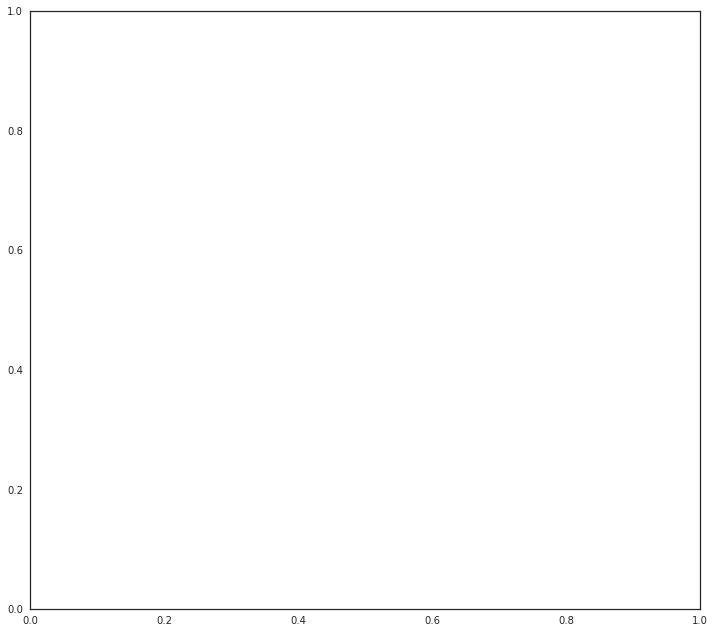

In [12]:
tab2.plot.scatter("LOC_X","LOC_Y",c="_CLUSTER_ID_",cmap=pylab.cm.autumn_r,figsize=(12,11),xlim=(-250,250),ylim=(422.5, -47.5))
draw_court()

Logistic

In [13]:
lr = sess.regression.logistic(
  table={"name":"kClusOutputScore"},
  classVars=[{"vars":{"_CLUSTER_ID_","Lead_Player_Before", "Homegame", "ACTION_TYPE",  "end_of_game","Overtime","close_game","pressure"},"descending":"True"}],
  model={
    "depVars":[{"name":"Made", "options":{"event":"1"}}],
    "effects":[{"vars":{"SHOT_DISTANCE","_CLUSTER_ID_", "ACTION_TYPE", "end_of_game","Overtime","close_game","pressure"}}]
  },
  
  outputTables={"names":"parameterestimates"}
)
sess.dataStep.runCode(
  code="""data round; set parameterestimates(keep=Parameter DF Estimate StdErr ChiSq ProbChisq); array _nums {*} _numeric_;
do i = 1 to dim(_nums);
  _nums{i} = round(_nums{i},.001);
end;
drop i;
run;"""
)
sess.fetch(table="round")

NOTE: Convergence criterion (ABSGCONV=1E-7) satisfied.
NOTE: There is possibly a quasi-complete separation of data points. More iterations are required to evaluate the covariances. The maximum likelihood estimate may not exist.
NOTE: The CAS table 'parameterestimates' in caslib 'CASUSER(sasdemo)' has 35 rows and 14 columns.
NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      18 at 0:150


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),parameterestimates,35,14,"CASTable('parameterestimates', caslib='CASUSER..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),round,35,6,"CASTable('round', caslib='CASUSER(sasdemo)')"


,Parameter,DF,Estimate,StdErr,ChiSq,ProbChiSq
0,Intercept,1.0,14.272,94.812,0.023,0.880
1,end_of_game Not End of Game,1.0,-0.161,0.135,1.428,0.232
2,end_of_game End of Game,0.0,0.000,NaN,NaN,NaN
3,close_game Not Close,1.0,-0.040,0.064,0.396,0.529
4,close_game Close Game,0.0,0.000,NaN,NaN,NaN
5,Overtime Regular,1.0,0.388,0.370,1.098,0.295
6,Overtime Overtime,0.0,0.000,NaN,NaN,NaN
7,ACTION_TYPE Tip Shot,1.0,-13.133,94.810,0.019,0.890
8,ACTION_TYPE Slam Dunk Shot,1.0,0.030,128.517,0.000,1.000
9,ACTION_TYPE Running Jump Shot,1.0,-12.982,94.811,0.019,0.891


Data Partitioning

In [14]:
sess.sampling.stratified(
  table={"name":"kClusOutputScore", "groupBy":"Made"},
  output={"casOut":{"name":"jordan_mining_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=575393021 for sampling.


[outputSize]

 {'outputNObs': 4809.0, 'outputNVars': 18}

[STRAFreq]

 Frequencies
 
    ByGrpID          Made  NObs  NSamp
 0        0             0  2538   1777
 1        1             1  2271   1590

[OutputCasTables]

              casLib                Name Label  Rows  Columns  \
 0  CASUSER(sasdemo)  jordan_mining_part        4809       18   
 
                                             casTable  
 0  CASTable('jordan_mining_part', caslib='CASUSER...  

+ Elapsed: 0.0132s, user: 0.014s, sys: 0.006s, mem: 11.1mb

### Random Forest

In [15]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"jordan_mining_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="Made",
  nTree=500,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  OOB=True,
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"jordan_mining_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"Made", "_partind_"},
  vote="PROB"
)

# Create p_Made0 and p_Made1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_Made1=_rf_predp_; 
    p_Made0=1-p_Made1; end; if _rf_predname_=0 then do; p_Made0=_rf_predp_; p_Made1=1-p_Made0; end; run;"""
)

Forest for JORDAN_MINING_PART 
 Descr 
 Value 
 
 
 Number of Trees 500 
 Number of Selected Variables (M) 4 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 12 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 343 
 Min Number of Tree Nodes 115 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 21 
 Min Number of Levels 13 
 Max Number of Leaves 172 
 Min Number of Leaves 58 
 Maximum Size of Leaves 1324 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) 42.678942679 
 
 
 
 
 OOB Error With Forest Analytics for JORDAN_MINING_PART 
 TreeID 
 Trees 
 NLeaves 
 MCR 
 LogLoss 
 ASE 
 RASE 
 MAXAE 
 
 
 0 1 117 0.4443194601 1.0177648669 0.25529228 0.5052645644 1 
 1 2 256 0.4397567465 0.9459054672 0.2540000251 0.5039841516 1 
 2 3 384 0.4380733945 0.8020317137 0.2498306371 0.4998306084 1 
 3 4 526 0.4342431762 0.8274807964 0.2491899304 0.4991892731 1 
 4 5 664 0.4369342185 0.7795128692 0.2466141901 0.4966026481 1 
 5 6 767 0.4386594853 0.7399933239 0.2437777429 0.493738537 1 
 6 7 879 0.4318046456 0.7150261173 0.2412958585 0.4912187481 1 
 7 8 992 0.4303571429 0.6860213847 0.2394147312 0.4893002465 1 
 8 9 1099 0.4305679453 0.6716730543 0.2384888331 0.4883531848 1 
 9 10 1226 0.4289536266 0.6729001507 0.2386633828 0.4885318647 1 
 10 11 1373 0.4249628529 0.6729403426 0.2387021805 0.4885715715 1 
 11 12 1477 0.4215686275 0.6649708845 0.2379064186 0.4877565157 0.9545454545 
 12 13 1593 0.4229284229 0.6643078843 0.2373004975 0.487134989 0.9642857143 
 13 14 1706 0.4211464211 0.663558179 0.2370459258 0.486873624 0.9642857143 
 14 15 1852 0.422037422 0.6636729613 0.2372195651 0.4870519121 0.9642857143 
 15 16 1963 0.4217404217 0.6640407486 0.2373908916 0.4872277615 0.9714285714 
 16 17 2107 0.4270864271 0.6631892629 0.2372751195 0.4871089401 0.9296536797 
 17 18 2217 0.4258984259 0.6621215173 0.2367703389 0.4865905249 0.9301559684 
 18 19 2344 0.4241164241 0.6621663952 0.2368426326 0.4866648052 0.9301559684 
 19 20 2480 0.4232254232 0.6620021244 0.2367782798 0.4865986846 0.9301559684 
 20 21 2611 0.4196614197 0.6620860496 0.2368997842 0.4867235193 0.9301559684 
 21 22 2718 0.4208494208 0.6616698278 0.2366607185 0.4864778705 0.9301559684 
 22 23 2863 0.4211464211 0.6612399093 0.2364844652 0.4862966844 0.9301559684 
 23 24 2976 0.4258984259 0.6609578188 0.2364147332 0.4862249821 0.9301559684 
 24 25 3055 0.4238194238 0.6609882686 0.2364296567 0.4862403281 0.9041780588 
 25 26 3210 0.425007425 0.6615327723 0.236709621 0.4865281297 0.9062530063 
 26 27 3344 0.4238194238 0.6614804062 0.2367251504 0.4865440889 0.9062530063 
 27 28 3446 0.4229284229 0.6610937222 0.2364471089 0.4862582738 0.9062530063 
 28 29 3561 0.4211464211 0.6607742547 0.2363506013 0.4861590288 0.9062530063 
 29 30 3671 0.4241164241 0.6612710054 0.2365371339 0.4863508342 0.9062530063 
 30 31 3814 0.4238194238 0.6615422442 0.2366898555 0.4865078164 0.9062530063 
 31 32 3946 0.4261954262 0.6615468078 0.2367143853 0.4865330259 0.9062530063 
 32 33 4094 0.4264924265 0.6612783096 0.236627336 0.4864435589 0.8958355239 
 33 34 4222 0.4267894268 0.6613608902 0.2366780393 0.4864956724 0.8958355239 
 34 35 4332 0.4270864271 0.6611441117 0.2365788262 0.4863936947 0.8958355239 
 35 36 4455 0.4258984259 0.661382254 0.2366929638 0.486511011 0.9013178648 
 36 37 4578 0.4226314226 0.6610162279 0.2365277715 0.486341209 0.9013178648 
 37 38 4664 0.4241164241 0.6611618656 0.2366045121 0.4864200983 0.9013178648 
 38 39 4815 0.4256014256 0.6608208093 0.2364697886 0.4862815939 0.9007897941 
 39 40 4908 0.4238194238 0.6606520763 0.2364179089 0.4862282477 0.9066256886 
 40 41 5036 0.4223344223 0.6605404088 0.2363795688 0.4861888201 0.9118131503 
 41 42 5135 0.4208494208 0.6605366989 0.2363855051 0.486194925 0.9164545634 
 42 43 5266 0.4247104247 0.6607429251 0.2364912788 0.4863036899 0.9206318353 
 43 44 5381 0.4258984259 0.6607516372 0.2364802601 0.4862923608 0.9206318353 
 44 45 5516 0.4261954262 0.6607

[OutputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_rf  4809        7   
 
                                             casTable  
 0  CASTable('_scored_rf', caslib='CASUSER(sasdemo)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                              4809
 1  Number of Observations Used                              4809
 2  Misclassification Error (%)                        36.5356623

+ Elapsed: 1.53s, user: 4.7s, sys: 0.702s, mem: 890mb

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:112
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:112  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_rf,4809,7,"CASTable('_scored_rf', caslib='CASUSER(sasdemo)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_rf,4809,9,"CASTable('_scored_rf', caslib='CASUSER(sasdemo)')"


### Gradient Boosting

In [16]:
gb = sess.decisionTree.gbtreeTrain(
  table={
    "name":"jordan_mining_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="Made",
  nTree=100,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Output model statistics
render_html(gb)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"jordan_mining_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={"Made", "_partind_"}
)

# Create p_Made0 and p_Made1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="""data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_Made1=_gbt_predp_; 
    p_Made0=1-p_Made1; end; if _gbt_predname_=0 then do; p_Made0=_gbt_predp_; p_Made1=1-p_Made0; end; run;"""
)

Gradient Boosting Tree for JORDAN_MINING_PART 
 Descr 
 Value 
 
 
 Number of Trees 100 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 12 
 Number of Bins 20 
 Number of Variables 12 
 Max Number of Tree Nodes 63 
 Min Number of Tree Nodes 29 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 32 
 Min Number of Leaves 15 
 Maximum Size of Leaves 1097 
 Minimum Size of Leaves 5 
 Random Number Seed 0 
 
 
 
 
 Decision Tree for JORDAN_MINING_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 _CLUSTER_ID_ 6.7671332605 1.130087023 
 ACTION_TYPE 5.1851331596 6.7912317161 
 SHOT_DISTANCE 3.8026689688 0.5519302474 
 Lead_Player_Before 2.4891930455 0.6450281783 
 SHOT_ZONE_AREA 1.9663570411 0.6304208677 
 SHOT_ZONE_BASIC 1.9125258684 0.9223705514 
 Homegame 1.7316765819 0.6104993827 
 close_game 1.5397731457 0.6787448038 
 end_of_game 1.0396618261 0.4973097975 
 pressure 0.5753530059 0.6694438707 
 SHOT_TYPE 0.4923365455 1.2333317095 
 Overtime 0.1590136158 0.3296496336 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(sasdemo) gb_model 4984 50 CASTable('gb_model', caslib='CASUSER(sasdemo)')

[OutputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_gb  4809        6   
 
                                             casTable  
 0  CASTable('_scored_gb', caslib='CASUSER(sasdemo)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                              4809
 1  Number of Observations Used                              4809
 2  Misclassification Error (%)                      36.161364109

[ErrorMetricInfo]

     TreeID  Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0      0.0    1.0     22.0  0.416303  0.683602  0.245239  0.495216  0.574606
 1      1.0    2.0     43.0  0.409233  0.677191  0.242065  0.492001  0.612897
 2      2.0    3.0     72.0  0.403826  0.671548  0.239314  0.489197  0.626856
 3      3.0    4.0     96.0  0.404242  0.666896  0.237109  0.486939  0.664479
 4      4.0    5.0    125.0  0.402163  0.662851  0.235245  0.485020  0.698865
 5      5.0    6.0    149.0  0.401955  0.659588  0.233803  0.483532  0.728892
 6      6.0    7.0    178.0  0.400291  0.656545  0.232473  0.482155  0.752832
 7      7.0    8.0    200.0  0.399251  0.654606  0.231695  0.481347  0.769612
 8      8.0    9.0    229.0  0.400499  0.652559  0.230881  0.480501  0.791835
 9      9.0   10.0    254.0  0.399043  0.650722  0.230161  0.479751  0.805554
 10    10.0   11.0    275.0  0.397588  0.649196  0.229602  0.479168  0.824589
 11    11.0   12.0    299.0  0.398212  0.647917  0.229154  0.478701  0.841425
 12    12.0   13.0    329.0  0.397796  0.647033  0.228887  0.478421  0.856682
 13    13.0   14.0    355.0  0.395300  0.646160  0.228597  0.478119  0.870408
 14    14.0   15.0    383.0  0.395716  0.645187  0.228267  0.477773  0.882879
 15    15.0   16.0    409.0  0.393637  0.644579  0.228076  0.477573  0.896310
 16    16.0   17.0    432.0  0.392805  0.643311  0.227581  0.477055  0.906298
 17    17.0   18.0    460.0  0.392805  0.642810  0.227433  0.476899  0.915272
 18    18.0   19.0    484.0  0.391142  0.642220  0.227210  0.476665  0.923359
 19    19.0   20.0    512.0  0.391350  0.641462  0.226898  0.476338  0.930699
 20    20.0   21.0    539.0  0.390518  0.640852  0.226684  0.476113  0.937484
 21    21.0   22.0    562.0  0.386775  0.640058  0.226373  0.475787  0.944108
 22    22.0   23.0    587.0  0.389686  0.639619  0.226217  0.475623  0.949481
 23    23.0   24.0    614.0  0.390726  0.639348  0.226161  0.475564  0.953663
 24    24.0   25.0    637.0  0.388022  0.638849  0.225973  0.475366  0.955287
 25    25.0   26.0    665.0  0.386567  0.638121  0.225667  0.475044  0.959582
 26    26.0   27.0    692.0  0.390310  0.637645  0.225482  0.474849  0.961792
 27    27.0   28.0    708.0  0.389062  0.637264  0.225338  0.474698  0.963739
 28    28.0   29.0    729.0  0.390310  0.636985  0.225260  0.474616  0.963606
 29    29.0   30.0    759.0  0.388438  0.636577  0.225079  0.474425  0.967020
 ..     ...    ...      ...       ...       ...       ...       ...       ...
 70    70.0   71.0   1790.0  0.374298  0.625199  0.220109  0.469158  0.990945
 71    71.0   72.0   1814.0  0.374298  0.625071  0.220051  0.469096  0.991170
 72    72.0   73.0   1842.0  0.374714  0.624804  0.219941  0.468978  0.991220
 73    73.0   74.0   1866.0  0.374714  0.624306  0.219693  0.468715  0.991291
 74    74.0   75.0   1895.0  0.373466  0.623939  0.219535  0.468546  0.991676
 75    75.0   76.0   1923.0  0.373258  0.623434  0.219278  0.468271  0.991644
 76    76.0   77.0   1951.0  0.369723  0.623562  0.219308  0.468304  0.992180
 77    77.0   78.0   1976.0  0.370139  0.623462  0.219218  0.468207  0.992935
 78    78.0   79.0   2000.0  0.371803  0.623370  0.219135  0.468119  0.993608
 79    79.0   80.0   2027.0  0.370971  0.623216  0.219053  0.468031  0.993567
 80    80.0   81.0   2055.0  0.372843  0.622598  0.218784  0.467743  0.993653
 81    81.0   82.0   2084.0  0.371595  0.621989  0.218483  0.467421  0.993607
 82    82.0   83.0   2109.0  0.3691

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:114
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:114  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_gb,4809,6,"CASTable('_scored_gb', caslib='CASUSER(sasdemo)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_gb,4809,8,"CASTable('_scored_gb', caslib='CASUSER(sasdemo)')"


### Neural Network

In [17]:
nn = sess.neuralNet.annTrain(
  table={
    "name":"jordan_mining_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"jordan_mining_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="Made",
  hiddens={1},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Output model statistics
render_html(nn)

# Score 
sess.neuralNet.annScore(
  table={"name":"jordan_mining_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"Made", "_partind_"}
)

# Create p_Made0 and p_Made1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="""data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_Made1=_nn_predp_; 
    p_Made0=1-p_Made1; end; if _nn_predname_=0 then do; p_Made0=_nn_predp_; p_Made1=1-p_Made0; end; run;"""
)

Iteration History 
 Progress 
 Objective 
 Loss 
 Validation Error 
 Step Size 
 L1 Norm 
 L2 Norm 
 MAX Norm 
 Gradient Norm 
 
 
 1 2.7756354975 2.7756354975 0.5332871012 0 0.8291572392 0.3573974833 0.3486721531 0.202232281 
 2 2.7606418179 2.7606418179 0.472260749 0.7959244836 1.0287952661 0.3642185822 0.3414775257 0.1321545522 
 3 2.7293765846 2.7293765846 0.4514563107 5 2.4266605002 0.5701024419 0.3564817641 0.1046648935 
 4 2.7038876843 2.7038876843 0.4590846047 1 5.4252290391 1.2020481778 0.5401562391 0.045929533 
 5 2.6968865408 2.6968865408 0.459778086 1 6.1979836517 1.3370265237 0.6001786549 0.0596564317 
 6 2.6924822571 2.6924822571 0.4715672677 1 7.5330707347 1.579964399 0.6934833305 0.1080630705 
 7 2.6883930853 2.6883930853 0.4632454924 1 7.486674007 1.5685968028 0.6965246265 0.0309926074 
 8 2.6850924223 2.6850924223 0.4563106796 1 7.2386702473 1.5099399879 0.6896684915 0.0660407641 
 9 2.6830998511 2.6830998511 0.4507628294 0.411597757 7.2505473529 1.4908497253 0.6862437859 0.0934628617 
 10 2.6804221866 2.6804221866 0.4466019417 0.3668944854 7.4506512427 1.5101095603 0.6986109345 0.1339253174 
 11 2.6737706704 2.6737706704 0.4507628294 1 8.0521922182 1.6276092515 0.7587805765 0.1928122764 
 12 2.6498264329 2.6498264329 0.4382801664 1 9.9991270174 2.0699654484 0.981302372 0.243477509 
 13 2.610415153 2.610415153 0.4424410541 1 14.580297263 3.0086394187 1.4549704738 0.0532877405 
 14 2.6060601403 2.6060601403 0.4355062413 1 16.954501012 3.4579448225 1.661651349 0.041577384 
 15 2.6050547367 2.6050547367 0.4285714286 1 17.875296438 3.6182657783 1.7010642733 0.0732144927 
 16 2.6030489409 2.6030489409 0.4278779473 1 18.031266017 3.6459588575 1.7130719075 0.0355643867 
 17 2.6003589775 2.6003589775 0.4251040222 1 18.150776642 3.6542111946 1.6960333623 0.0354627627 
 18 2.5973744082 2.5973744082 0.4264909847 1 18.068044399 3.6084382469 1.6465693355 0.0485724418 
 19 2.5918101865 2.5918101865 0.4327323162 1 18.192699084 3.5890165587 1.5867608962 0.0708592756 
 20 2.5884708736 2.5884708736 0.4264909847 1 18.529221934 3.6612092437 1.5452494711 0.1058096717 
 21 2.5841005093 2.5841005093 0.427184466 0.4952562158 18.041781609 3.5985946308 1.5020767839 0.0427759787 
 22 2.5831968037 2.5831968037 0.4361997226 1 17.477956521 3.5294646918 1.5317597162 0.0328241566 
 23 2.5809267165 2.5809267165 0.4341192788 1 18.034520394 3.6301956478 1.5443994941 0.0578032294 
 24 2.5788130098 2.5788130098 0.4313453537 1 18.846291575 3.7822122176 1.5578353363 0.0432931045 
 25 2.5762824838 2.5762824838 0.4313453537 1 19.421954849 3.9299483319 1.606371585 0.0386674282 
 26 2.5737225051 2.5737225051 0.4341192788 1 20.901549336 4.308568153 1.7609999826 0.0629314899 
 27 2.5722495571 2.5722495571 0.427184466 1 20.688689612 4.2554932158 1.762806595 0.0215430374 
 28 2.5720235575 2.5720235575 0.4292649098 1 20.511082162 4.2148912261 1.7583228137 0.0146985744 
 29 2.571508453 2.571508453 0.4264909847 1 20.548211504 4.2405553257 1.7835404576 0.0246558406 
 30 2.570507855 2.570507855 0.4341192788 1 20.849639722 4.3208031384 1.8439081834 0.0209012517 
 31 2.570048699 2.570048699 0.4299583911 1 21.049693683 4.3589012674 1.8618370209 0.0377342817 
 32 2.5696553875 2.5696553875 0.4285714286 1 21.098700489 4.3699881803 1.8603370574 0.0172154 
 33 2.5695214057 2.5695214057 0.4285714286 1 21.135636987 4.3774334438 1.8622877065 0.0145960798 
 34 2.569196693 2.569196693 0.427184466 1 21.232270651 4.4026282556 1.8769439669 0.0137468424 
 35 2.5686701118 2.5686701118 0.427184466 1 21.397447185 4.4519569044 1.913272278 0.0167921204 
 36 2.5685425478 2.5685425478 0.4278779473 0.2071723448 21.464087765 4.4690868429 1.9239120577 0.0227993167 
 37 2.5683083192 2.5683083192 0.427184466 1 21.595327758 4.5031081802 1.9492591262 0.0191140332 
 38 2.5679028536 2.5679028536 0.4244105409 1 21.855167517 4.5606288122 1.9971685123 0.0186007986 
 39 2.5674768025 2.5674768025 0.4278779473 1 22.088926344 4.6048398067 2.0327936717 0.0194397662 
 40 2.5664949825 2.5664949825 0.42

[OutputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_nn  4809        4   
 
                                             casTable  
 0  CASTable('_scored_nn', caslib='CASUSER(sasdemo)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                              4809
 1  Number of Observations Used                              4809
 2  Misclassification Error (%)                      40.195466833

+ Elapsed: 0.00695s, user: 0.017s, mem: 8.57mb

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:112
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:112  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_nn,4809,4,"CASTable('_scored_nn', caslib='CASUSER(sasdemo)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_nn,4809,6,"CASTable('_scored_nn', caslib='CASUSER(sasdemo)')"


### Assess Models

In [18]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_Made1"}],      
      response="Made",
      event="1",
      pVar={"p_Made0"},
      pEvent={"0"}      
    )

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo



### Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [19]:
# Add new variable to indicate type of model
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"

# Append data
all_liftinfo=rf_liftinfo.append(gb_liftinfo, ignore_index=True) \
    .append(nn_liftinfo, ignore_index=True)  
all_rocinfo=rf_rocinfo.append(gb_rocinfo, ignore_index=True) \
    .append(nn_rocinfo, ignore_index=True) 

#### Print AUC (Area Under the ROC Curve)

In [20]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.576854
100,GradientBoosting,0.573937
200,NeuralNetwork,0.564584


#### Draw ROC and Lift plots

/opt/sasinside/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


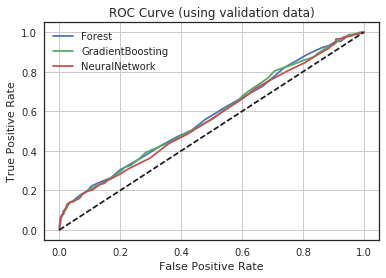

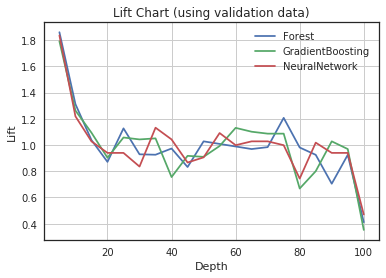

In [21]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

### End CAS session

In [22]:
sess.close()